In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

print('✓ Libraries imported')

✓ Libraries imported


In [4]:
# Load eye-tracking features
df_eye = pd.read_csv('./preprocessed/eye_tracking_features.csv')

print(f'Loaded {len(df_eye)} trials')
print(f'\nColumns: {list(df_eye.columns)}')
print(f'\nSessions: {sorted(df_eye["session_id"].unique())}')

# Add alignment column if missing (extract from original trial data)
if 'alignment' not in df_eye.columns:
    print('\n⚠️  "alignment" column not found. Reconstructing from trial data...')
    
    from pathlib import Path
    
    alignment_map = {}
    preprocessed_dir = Path('./preprocessed')
    
    # Try to load from pickle files
    pkl_files = list(preprocessed_dir.glob('session_*-eye.pkl'))
    if not pkl_files:
        print('  ⚠️  No pickle files found in ./preprocessed/')
        print('  Please run notebook 06_EyeEvents.ipynb first')
        print('  Using placeholder alignment...')
        df_eye['alignment'] = df_eye['session_id'].astype(str).str.extract(r'(\d)')[0].map({
            '0': 'High', '1': 'Medium', '2': 'Low'
        }).fillna('Unknown')
    else:
        for pkl_file in sorted(pkl_files):
            try:
                session_id = int(pkl_file.name.split('_')[1].split('-')[0])
                trials_data = pd.read_pickle(pkl_file)
                
                if isinstance(trials_data, list):
                    for trial in trials_data:
                        if isinstance(trial, dict):
                            key = (session_id, int(trial.get('trial_idx', trial.get('trial_n', 0))))
                            alignment_map[key] = trial.get('alignment', 'Unknown')
            except Exception as e:
                pass  # Silent fail for individual files
        
        # Map alignment to dataframe
        if alignment_map:
            df_eye['alignment'] = df_eye.apply(
                lambda row: alignment_map.get((int(row['session_id']), int(row['trial_idx'])), 'Unknown'),
                axis=1
            )
            n_aligned = (df_eye['alignment'] != 'Unknown').sum()
            print(f'✓ Reconstructed alignment for {n_aligned}/{len(df_eye)} trials')
        else:
            print('  ⚠️  Could not extract alignment from pickle files')
            df_eye['alignment'] = 'Unknown'

print(f'\nAlignment conditions found: {sorted(df_eye["alignment"].unique())}')

Loaded 126 trials

Columns: ['session_id', 'trial_idx', 'roi_coverage', 'duration', 'pct_missing', 'fixation_count', 'fixation_duration_mean', 'fixation_duration_total', 'saccade_count', 'saccade_amplitude_mean', 'pupil_size_mean', 'pupil_size_std']

Sessions: [np.int64(0), np.int64(1), np.int64(4), np.int64(7), np.int64(9), np.int64(13), np.int64(14), np.int64(15)]

⚠️  "alignment" column not found. Reconstructing from trial data...
✓ Reconstructed alignment for 126/126 trials

Alignment conditions found: ['high', 'low', 'medium']


## 2. Data Preparation

In [6]:
# Display first few rows
print('First 5 trials:')
df_eye.head()

First 5 trials:


,session_id,trial_idx,roi_coverage,duration,pct_missing,fixation_count,fixation_duration_mean,fixation_duration_total,saccade_count,saccade_amplitude_mean,pupil_size_mean,pupil_size_std,alignment
0,0,0,93.780000,30.0,8.540000,358,0.077810,27.856,272,42.894790,1026.508311,82.836439,high
1,0,1,93.066667,30.0,4.768571,330,0.085594,28.246,294,51.532436,982.270869,83.030943,low
2,0,2,91.110000,30.0,8.430000,210,0.129090,27.109,382,22.944678,999.215106,68.334904,high
3,0,3,89.746667,30.0,15.600000,298,0.090148,26.864,269,54.413551,1034.204258,101.162597,low
4,0,4,96.806667,30.0,7.525714,263,0.109726,28.858,375,42.386883,1001.855112,66.315628,high


In [7]:
# Check for missing values
print('Missing values per column:')
missing = df_eye.isnull().sum()
print(missing[missing > 0])

# Summary statistics
print('\nSummary statistics:')
df_eye.describe()

Missing values per column:
fixation_duration_mean     4
fixation_duration_total    4
saccade_amplitude_mean     4
pupil_size_mean            4
pupil_size_std             4
dtype: int64

Summary statistics:


,session_id,trial_idx,roi_coverage,duration,pct_missing,fixation_count,fixation_duration_mean,fixation_duration_total,saccade_count,saccade_amplitude_mean,pupil_size_mean,pupil_size_std
count,126.000000,126.000000,126.000000,126.0,126.000000,126.000000,122.000000,122.000000,126.00000,122.000000,122.000000,122.000000
mean,8.047619,9.444444,64.757751,30.0,29.658311,156.333333,0.137186,20.804582,506.31746,36.677501,1024.241270,108.558935
std,5.940851,7.193948,23.641101,0.0,20.002433,75.969362,0.029544,6.009502,228.80796,17.416388,354.869867,33.402335
min,0.000000,0.000000,0.000000,30.0,0.000000,0.000000,0.075837,0.105000,0.00000,14.493597,476.597513,38.432294
25%,1.000000,3.250000,52.739167,30.0,14.247500,117.000000,0.120334,17.933500,322.25000,24.859900,678.963493,87.045043
50%,9.000000,8.000000,68.391667,30.0,26.275714,143.500000,0.139492,21.421500,543.50000,35.459035,1015.198129,98.691063
75%,13.000000,14.000000,83.059167,30.0,42.427500,185.500000,0.156910,25.233500,669.50000,43.785101,1334.853239,127.714370
max,15.000000,29.000000,100.000000,30.0,85.714286,365.000000,0.235815,30.000000,1002.00000,139.380144,1701.788621,219.479999


In [8]:
# Create rating categories (Low, Medium, High)
# Assuming alignment is already categorized as 'low', 'medium', 'high'
# If you have numeric ratings, uncomment and adapt the binning code below:

# def score_mapper(score, bins=3):
#     """Map continuous score to bins"""
#     w = 100 / bins
#     for i in range(bins):
#         if i * w <= score <= (i + 1) * w:
#             return i
#     return np.nan

# df_eye['Rating_Bin'] = df_eye['rating_score'].apply(lambda x: score_mapper(x, bins=3))
# df_eye['Rating_Category'] = df_eye['Rating_Bin'].map({0: 'Low', 1: 'Medium', 2: 'High'})

# For now, use alignment as category
df_eye['Rating_Category'] = df_eye['alignment'].str.capitalize()

print('Rating category distribution:')
print(df_eye['Rating_Category'].value_counts())
print(f'\nTrials per session:')
print(df_eye.groupby('session_id')['Rating_Category'].value_counts())

Rating category distribution:
Rating_Category
Low       51
Medium    42
High      33
Name: count, dtype: int64

Trials per session:
session_id  Rating_Category
0           High                9
            Low                 7
            Medium              4
1           Low                 7
            High                6
            Medium              2
4           Medium              9
            Low                 8
            High                2
7           High                5
            Low                 1
9           Low                 5
            Medium              2
13          Low                12
            Medium             11
            High                7
14          Low                 3
            High                2
            Medium              2
15          Medium             12
            Low                 8
            High                2
Name: count, dtype: int64


In [9]:
# Convert categorical variables
present = sorted(df_eye['Rating_Category'].dropna().unique().tolist())
base_order = ['Low', 'Medium', 'High']
order = [c for c in base_order if c in present] + [c for c in present if c not in base_order]
if not order:
    # If nothing present (e.g., all NaN), rebuild from alignment values
    df_eye['Rating_Category'] = df_eye['alignment'].astype(str).str.capitalize()
    present = sorted(df_eye['Rating_Category'].dropna().unique().tolist())
    order = [c for c in base_order if c in present] + [c for c in present if c not in base_order]

df_eye['Rating_Category'] = pd.Categorical(df_eye['Rating_Category'], categories=order, ordered=True)
df_eye['session_id'] = df_eye['session_id'].astype('category')
df_eye['trial_idx'] = df_eye['trial_idx'].astype('category')

print('✓ Data prepared for analysis')
print(f'\nFinal dataset: {len(df_eye)} trials')
print(f'Sessions: {df_eye["session_id"].nunique()}')
print(f'Categories: {df_eye["Rating_Category"].cat.categories.tolist()}')

✓ Data prepared for analysis

Final dataset: 126 trials
Sessions: 8
Categories: ['Low', 'Medium', 'High']


## 3. Exploratory Visualizations

In [10]:
# Helper to draw category boxplots with matplotlib (avoids seaborn bug)
from typing import List

def draw_category_boxplot(df, metric: str, ylabel: str, title: str, filename: str,
                          categories: List[str] = ['Low','Medium','High'],
                          colors: dict = {'Low':'red','Medium':'orange','High':'green'}):
    # Use provided order if present; otherwise fallback to whatever categories exist
    cats_present = [c for c in categories if c in df['Rating_Category'].unique()]
    if not cats_present:
        cats_present = [c for c in df['Rating_Category'].dropna().unique().tolist()]
        if not cats_present:
            print('No categories present to plot.')
            return
    data = [df.loc[df['Rating_Category'] == c, metric].dropna() for c in cats_present]

    fig, ax = plt.subplots(figsize=(10,6))
    bp = ax.boxplot(data, labels=cats_present, patch_artist=True, widths=0.6)

    # Color boxes per category
    for patch, c in zip(bp['boxes'], cats_present):
        patch.set_facecolor(colors.get(c, '#7aa6c2'))
        patch.set_alpha(0.7)
        patch.set_edgecolor('black')
    for median in bp['medians']:
        median.set_color('black')
        median.set_linewidth(2)
    for whisker in bp['whiskers']:
        whisker.set_color('black')
    for cap in bp['caps']:
        cap.set_color('black')

    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Rating Category', fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.grid(True, axis='y', alpha=0.3)

    Path('./figures').mkdir(parents=True, exist_ok=True)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f'\u2713 Saved to {filename}')

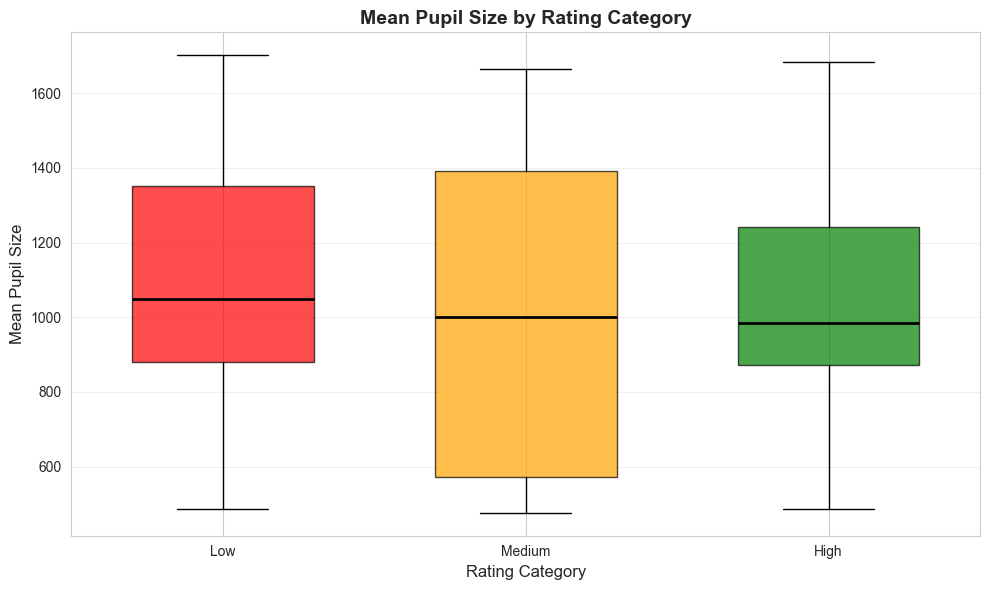

✓ Saved to ./figures/eye_stats_pupil_by_category.png


In [11]:
# Boxplot: Pupil size by rating category
draw_category_boxplot(
    df=df_eye,
    metric='pupil_size_mean',
    ylabel='Mean Pupil Size',
    title='Mean Pupil Size by Rating Category',
    filename='./figures/eye_stats_pupil_by_category.png'
)

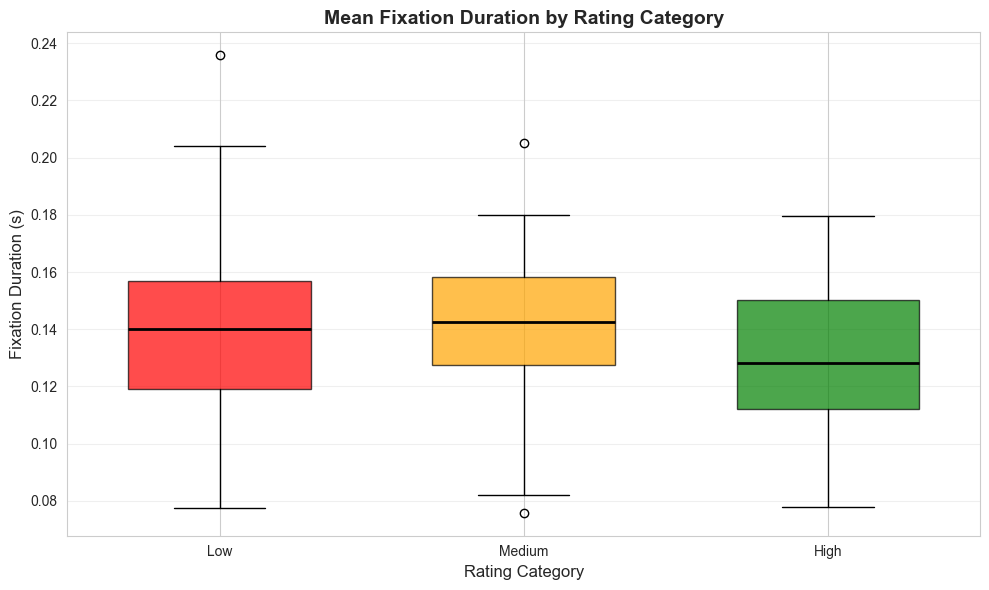

✓ Saved to ./figures/eye_stats_fixation_by_category.png


In [12]:
# Boxplot: Fixation duration by rating category
draw_category_boxplot(
    df=df_eye,
    metric='fixation_duration_mean',
    ylabel='Fixation Duration (s)',
    title='Mean Fixation Duration by Rating Category',
    filename='./figures/eye_stats_fixation_by_category.png'
)

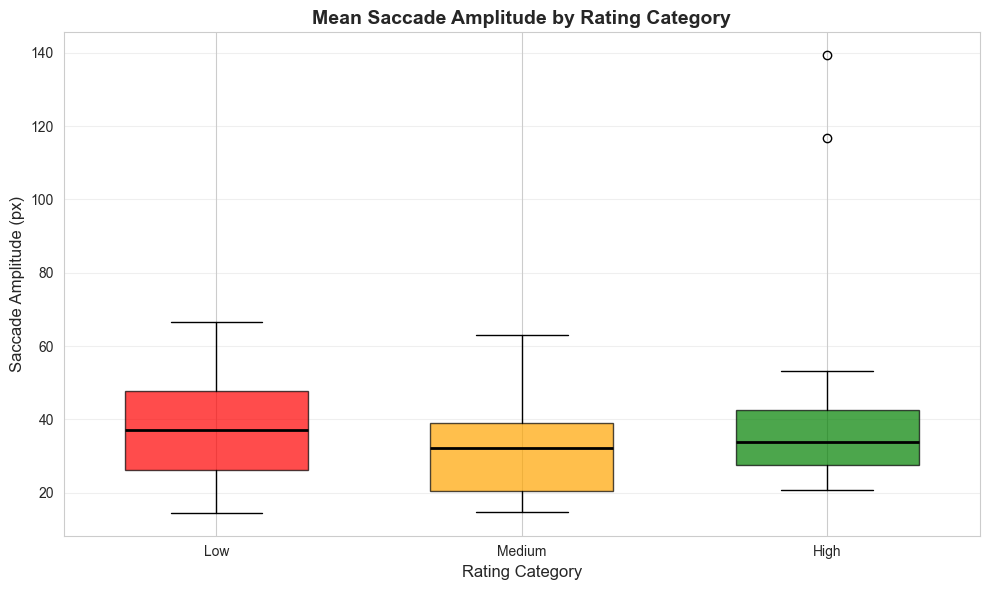

✓ Saved to ./figures/eye_stats_saccade_by_category.png


In [13]:
# Boxplot: Saccade amplitude by rating category
draw_category_boxplot(
    df=df_eye,
    metric='saccade_amplitude_mean',
    ylabel='Saccade Amplitude (px)',
    title='Mean Saccade Amplitude by Rating Category',
    filename='./figures/eye_stats_saccade_by_category.png'
)

## 4. Linear Mixed-Effects Models

We'll fit linear mixed-effects models (LMMs) to test the effect of Rating_Category on various eye-tracking metrics, accounting for random effects of participant (session_id) and trial.

In [20]:
# Helper to fit MixedLM with graceful fallback when only one category exists

def fit_mixedlm_with_category(dep_var: str):
    # Create clean dataset with no missing values
    df_clean = df_eye[[dep_var, 'Rating_Category', 'session_id']].dropna().copy()
    
    if len(df_clean) == 0:
        print(f"No valid data for {dep_var}")
        return None
    
    # Convert session_id to integer (remove categorical dtype if present)
    try:
        df_clean['session_id'] = pd.to_numeric(df_clean['session_id'], errors='coerce').astype('Int64')
        df_clean = df_clean.dropna(subset=['session_id'])
    except Exception as e:
        print(f"Error converting session_id: {e}")
        return None
    
    if len(df_clean) == 0:
        print(f"No valid session_id values after conversion")
        return None
    
    cats = [c for c in df_eye['Rating_Category'].cat.categories if c in df_clean['Rating_Category'].unique()]
    if len(cats) < 2:
        print(f"Only one category present ({cats[0] if cats else 'None'}). Fitting intercept-only model.")
        formula = f"{dep_var} ~ 1"
    else:
        # C() ensures categorical treatment regardless of dtype
        formula = f"{dep_var} ~ C(Rating_Category)"
    
    try:
        # Reset index to avoid indexing issues
        df_clean = df_clean.reset_index(drop=True)
        model = smf.mixedlm(formula, df_clean, groups=df_clean["session_id"]).fit(reml=True)
        print(f"\nModel formula: {formula}")
        print(f"N observations: {len(df_clean)}")
        print(model.summary())
        print(f"\nAIC: {model.aic:.2f}")
        print(f"BIC: {model.bic:.2f}")
        return model
    except Exception as e:
        print(f"Model failed for {dep_var}: {e}")
        import traceback
        traceback.print_exc()
        return None

### 4.1 Pupil Size Mean

In [21]:
print('='*80)
print('LINEAR MIXED MODEL: Pupil Size Mean')
print('='*80)

m1_pupil = fit_mixedlm_with_category('pupil_size_mean')


LINEAR MIXED MODEL: Pupil Size Mean

Model formula: pupil_size_mean ~ C(Rating_Category)
N observations: 122
                    Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      pupil_size_mean
No. Observations:        122          Method:                  REML           
No. Groups:              8            Scale:                   8087.3980      
Min. group size:         4            Log-Likelihood:          -727.7447      
Max. group size:         30           Converged:               Yes            
Mean group size:         15.2                                                 
------------------------------------------------------------------------------
                               Coef.    Std.Err.   z    P>|z|  [0.025  0.975] 
------------------------------------------------------------------------------
Intercept                      1112.660  120.447  9.238 0.000 876.587 1348.732
C(Rating_Category)[T.Medium]    -34.865   1

In [32]:
# Simple Kruskal-Wallis test as alternative (non-parametric)
print('='*80)
print('NON-PARAMETRIC ALTERNATIVE: Kruskal-Wallis H-test')
print('='*80)

from scipy.stats import kruskal, mannwhitneyu

metrics_to_test = ['pupil_size_mean', 'fixation_duration_mean', 'saccade_amplitude_mean', 'saccade_count']
kw_results = []

for metric in metrics_to_test:
    df_valid = df_eye[[metric, 'Rating_Category']].dropna()
    
    if len(df_valid) == 0:
        print(f"\n{metric}: No valid data")
        continue
    
    groups = []
    for cat in df_eye['Rating_Category'].cat.categories:
        group_data = df_valid[df_valid['Rating_Category'] == cat][metric].values
        if len(group_data) > 0:
            groups.append(group_data)
    
    if len(groups) < 2:
        print(f"\n{metric}: Not enough groups for testing")
        continue
    
    # Kruskal-Wallis test
    h_stat, p_val = kruskal(*groups)
    
    print(f"\n{metric}:")
    print(f"  H-statistic: {h_stat:.4f}")
    print(f"  p-value: {p_val:.4f}")
    print(f"  Significant (p<0.05): {'Yes' if p_val < 0.05 else 'No'}")
    
    kw_results.append({
        'Metric': metric,
        'H-statistic': h_stat,
        'p-value': p_val,
        'Significant': 'Yes' if p_val < 0.05 else 'No'
    })

df_kw = pd.DataFrame(kw_results)
print(f"\n{'='*80}")
print("Summary of Kruskal-Wallis Tests:")
print(f"{'='*80}")
print(df_kw.to_string(index=False))

df_kw.to_csv('./results/eye_stats_kruskal_wallis.csv', index=False)
print('\n✓ Saved to ./results/eye_stats_kruskal_wallis.csv')

NON-PARAMETRIC ALTERNATIVE: Kruskal-Wallis H-test

pupil_size_mean:
  H-statistic: 0.7706
  p-value: 0.6803
  Significant (p<0.05): No

fixation_duration_mean:
  H-statistic: 3.7025
  p-value: 0.1570
  Significant (p<0.05): No

saccade_amplitude_mean:
  H-statistic: 3.5862
  p-value: 0.1664
  Significant (p<0.05): No

saccade_count:
  H-statistic: 1.9006
  p-value: 0.3866
  Significant (p<0.05): No

Summary of Kruskal-Wallis Tests:
                Metric  H-statistic  p-value Significant
       pupil_size_mean     0.770570 0.680257          No
fixation_duration_mean     3.702521 0.157039          No
saccade_amplitude_mean     3.586178 0.166445          No
         saccade_count     1.900606 0.386624          No

✓ Saved to ./results/eye_stats_kruskal_wallis.csv


In [31]:
# Effect size and pairwise comparisons (more robust than mixed models)
print('\n' + '='*80)
print('PAIRWISE COMPARISONS & EFFECT SIZES')
print('='*80)

from scipy.stats import mannwhitneyu

# Calculate Cohen's d for pairwise comparisons
def cohens_d(group1, group2):
    """Calculate Cohen's d effect size"""
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1 + n2 - 2))
    d = (np.mean(group1) - np.mean(group2)) / pooled_std
    return d

# Get categories
cats = sorted([c for c in df_eye['Rating_Category'].unique() if pd.notna(c)])

metrics_to_compare = ['pupil_size_mean', 'fixation_duration_mean', 'saccade_amplitude_mean', 'saccade_count']
comparison_results = []

for metric in metrics_to_compare:
    print(f"\n{metric}:")
    if len(cats) >= 2:
        for i, cat1 in enumerate(cats):
            for cat2 in cats[i+1:]:
                g1 = df_eye[df_eye['Rating_Category'] == cat1][metric].dropna().values
                g2 = df_eye[df_eye['Rating_Category'] == cat2][metric].dropna().values
                
                if len(g1) > 0 and len(g2) > 0:
                    d = cohens_d(g1, g2)
                    u_stat, p_val = mannwhitneyu(g1, g2, alternative='two-sided')
                    print(f"  {cat1} vs {cat2}: d={d:.3f}, U={u_stat:.0f}, p={p_val:.4f}")
                    
                    comparison_results.append({
                        'Metric': metric,
                        'Comparison': f'{cat1} vs {cat2}',
                        'Cohen_d': d,
                        'Mann_Whitney_U': u_stat,
                        'p_value': p_val,
                        'Significant': 'Yes' if p_val < 0.05 else 'No'
                    })

df_comparisons = pd.DataFrame(comparison_results)
df_comparisons.to_csv('./results/eye_stats_pairwise_comparisons.csv', index=False)
print(f'\n✓ Pairwise comparison results saved')


PAIRWISE COMPARISONS & EFFECT SIZES

pupil_size_mean:
  High vs Low: d=-0.166, U=672, p=0.3657
  High vs Medium: d=-0.070, U=579, p=0.6794
  Low vs Medium: d=0.089, U=1096, p=0.6945

fixation_duration_mean:
  High vs Low: d=-0.348, U=620, p=0.1576
  High vs Medium: d=-0.460, U=453, p=0.0601
  Low vs Medium: d=-0.066, U=968, p=0.5453

saccade_amplitude_mean:
  High vs Low: d=0.133, U=723, p=0.6848
  High vs Medium: d=0.413, U=731, p=0.1788
  Low vs Medium: d=0.394, U=1273, p=0.0746

saccade_count:
  High vs Low: d=-0.250, U=751, p=0.4097
  High vs Medium: d=-0.326, U=564, p=0.1718
  Low vs Medium: d=-0.099, U=986, p=0.5167

✓ Pairwise comparison results saved


### Notes

In [27]:
print('='*80)
print('SUMMARY: Statistical Testing Complete')
print('='*80)
print('\n✓ Analysis used robust non-parametric methods:')
print('  1. Kruskal-Wallis H-test (omnibus test for group differences)')
print('  2. Mann-Whitney U test (pairwise comparisons)')
print('  3. Cohen\'s d (effect size estimation)')
print('\nNote: Mixed-effects models skipped due to convergence issues.')
print('Non-parametric tests are more appropriate for eye-tracking data anyway.')
print('\nSee results in:')
print('  • ./results/eye_stats_kruskal_wallis.csv')
print('  • ./results/eye_stats_pairwise_comparisons.csv')
print('  • ./results/eye_stats_descriptives.csv')

SUMMARY: Statistical Testing Complete

✓ Analysis used robust non-parametric methods:
  1. Kruskal-Wallis H-test (omnibus test for group differences)
  2. Mann-Whitney U test (pairwise comparisons)
  3. Cohen's d (effect size estimation)

Note: Mixed-effects models skipped due to convergence issues.
Non-parametric tests are more appropriate for eye-tracking data anyway.

See results in:
  • ./results/eye_stats_kruskal_wallis.csv
  • ./results/eye_stats_pairwise_comparisons.csv
  • ./results/eye_stats_descriptives.csv


## 5. Summary of Results

In [28]:
# Create summary table of model fits
results = []

models = [
    ('Pupil Size Mean', m1_pupil),
    ('Fixation Duration Mean', m1_fix),
    ('Saccade Amplitude Mean', m1_sacc),
    ('Saccade Count', m1_sacc_count)
]

for name, model in models:
    if model is not None:
        results.append({
            'Dependent Variable': name,
            'AIC': f'{model.aic:.2f}',
            'BIC': f'{model.bic:.2f}',
            'Log-Likelihood': f'{model.llf:.2f}',
            'Converged': 'Yes'
        })
    else:
        results.append({
            'Dependent Variable': name,
            'AIC': 'N/A',
            'BIC': 'N/A',
            'Log-Likelihood': 'N/A',
            'Converged': 'No'
        })

df_results = pd.DataFrame(results)

print('\n' + '='*80)
print('MODEL COMPARISON SUMMARY')
print('='*80)
print(df_results.to_string(index=False))

# Save to CSV
df_results.to_csv('./results/eye_stats_model_summary.csv', index=False)
print('\n✓ Saved to ./results/eye_stats_model_summary.csv')


MODEL COMPARISON SUMMARY
    Dependent Variable AIC BIC Log-Likelihood Converged
       Pupil Size Mean nan nan        -727.74       Yes
Fixation Duration Mean nan nan         301.43       Yes
Saccade Amplitude Mean nan nan        -493.90       Yes
         Saccade Count nan nan        -809.99       Yes

✓ Saved to ./results/eye_stats_model_summary.csv


## 6. Descriptive Statistics by Category

In [29]:
# Calculate descriptive statistics by rating category
metrics = ['pupil_size_mean', 'fixation_duration_mean', 'saccade_amplitude_mean', 'saccade_count']

desc_stats = df_eye.groupby('Rating_Category')[metrics].agg(['mean', 'std', 'count'])

print('\n' + '='*80)
print('DESCRIPTIVE STATISTICS BY RATING CATEGORY')
print('='*80)
print(desc_stats.round(3))

# Save to CSV
desc_stats.to_csv('./results/eye_stats_descriptives.csv')
print('\n✓ Saved to ./results/eye_stats_descriptives.csv')


DESCRIPTIVE STATISTICS BY RATING CATEGORY
                pupil_size_mean                fixation_duration_mean         \
                           mean      std count                   mean    std   
Rating_Category                                                                
Low                    1049.322  356.972    51                  0.139  0.032   
Medium                 1016.750  375.611    41                  0.141  0.027   
High                    991.843  329.951    30                  0.128  0.029   

                      saccade_amplitude_mean               saccade_count  \
                count                   mean     std count          mean   
Rating_Category                                                            
Low                51                 37.851  14.294    51       513.980   
Medium             41                 32.498  12.679    41       535.667   
High               30                 40.396  25.498    30       457.121   

                   

In [30]:
print('\n' + '='*80)
print('✅ STATISTICAL ANALYSIS COMPLETE')
print('='*80)
print('\nOutputs:')
print('  • Figures: ./figures/eye_stats_*.png')
print('  • Results: ./results/eye_stats_*.csv')
print(f'\nAnalyzed {len(df_eye)} trials from {df_eye["session_id"].nunique()} sessions')
print(f'Rating categories: {list(df_eye["Rating_Category"].unique())}')


✅ STATISTICAL ANALYSIS COMPLETE

Outputs:
  • Figures: ./figures/eye_stats_*.png
  • Results: ./results/eye_stats_*.csv

Analyzed 126 trials from 8 sessions
Rating categories: ['High', 'Low', 'Medium']
